## Photometry Cookbook
This notebook will represent a standard cookbook for performing SLUGGS survey photometry on ground-based data.

In [6]:
#standard imports
%matplotlib inline
import seWrapper
from imp import reload
import os
import matplotlib.pyplot as plt
import numpy as np
reload(seWrapper)

import pandas as pd

In [7]:
g_band_data = pd.read_csv('n4486_g_final.csv')
r_band_data = pd.read_csv('n4486_r_final.csv')
i_band_data = pd.read_csv('n4486_i_final.csv')

In [8]:
se_g = seWrapper.seCatalog()
se_g.create_new_catalog_arrs(g_band_data['ra'],\
                        g_band_data['dec'],\
                           fil='g',\
                        mags = g_band_data['mag'],
                        fwhm = g_band_data['fwhm'],
                       flags = g_band_data['flag'],
                       ellipticity = g_band_data['ellip'],
                        merr = g_band_data['merr'])

In [9]:
se_r = seWrapper.seCatalog()
se_r.create_new_catalog_arrs(r_band_data['ra'],\
                        r_band_data['dec'],\
                           fil='r',\
                        mags = r_band_data['mag'],
                        fwhm = r_band_data['fwhm'],
                       flags = r_band_data['flag'],
                       ellipticity = r_band_data['ellip'],
                            merr = r_band_data['merr'])

In [10]:
se_i = seWrapper.seCatalog()
se_i.create_new_catalog_arrs(i_band_data['ra'],\
                        i_band_data['dec'],\
                           fil='i',\
                        mags = i_band_data['mag'],
                        fwhm = i_band_data['fwhm'],
                       flags = i_band_data['flag'],
                       ellipticity = i_band_data['ellip'],
                            merr = i_band_data['merr'])

In [11]:
se_g.mergeCatalog(se_r)


In [12]:
se_g.mergeCatalog(se_i)

In [13]:
all_detections = (se_g.mags['g'] < 90) & (se_g.mags['r'] < 90) & (se_g.mags['i'] < 90) 

In [14]:
gi_all_detections = se_g.mags['g'][all_detections] - se_g.mags['i'][all_detections]

In [15]:
se_g.coords.ra.degree

array([ 187.7093282,  187.3737354,  187.8328418, ...,  187.9955433,
        188.1592483,  188.1448249])

In [16]:
#Now that catalogs are joined, put everything in a pandas data frame. Note that if I had written
#my catalog code a year later, it would be written with the intention of doing this from the beginning...
catalog_dict = {}

#get the ra and dec from the coordinate object and place them in a pandas series
catalog_dict['ra'] = pd.Series(se_g.coords.ra.degree)
catalog_dict['dec'] = pd.Series(se_g.coords.dec.degree)

#put the mags in pandas series:
catalog_dict['g_mag'] = pd.Series(se_g.mags['g'])
catalog_dict['r_mag'] = pd.Series(se_g.mags['r'])
catalog_dict['i_mag'] = pd.Series(se_g.mags['i'])

#same for the merrs:
catalog_dict['g_merr'] = pd.Series(se_g.merr['g'])
catalog_dict['r_merr'] = pd.Series(se_g.merr['r'])
catalog_dict['i_merr'] = pd.Series(se_g.merr['i'])

#same for the fwhm:
catalog_dict['g_fwhm'] = pd.Series(se_g.fwhm['g'])
catalog_dict['r_fwhm'] = pd.Series(se_g.fwhm['r'])
catalog_dict['i_fwhm'] = pd.Series(se_g.fwhm['i'])

#same for the ellipticity:
catalog_dict['g_ellip'] = pd.Series(se_g.ellipticity['g'])
catalog_dict['r_ellip'] = pd.Series(se_g.ellipticity['r'])
catalog_dict['i_ellip'] = pd.Series(se_g.ellipticity['i'])

#same for the flags:
catalog_dict['g_flags'] = pd.Series(se_g.flags['g'])
catalog_dict['r_flags'] = pd.Series(se_g.flags['r'])
catalog_dict['i_flags'] = pd.Series(se_g.flags['i'])

In [17]:
catalog = pd.DataFrame(catalog_dict)

In [18]:
catalog.to_csv('n4486_phot_combined.csv')

In [19]:
detected = (catalog['g_mag'] < 90) & (catalog['r_mag'] < 90) & (catalog['i_mag'] < 90)

In [20]:
detections = catalog.ix[detected,:]

In [21]:
good_source = (detections['i_fwhm'] > 2.5) & (detections['i_fwhm'] < 3.0)
good_sources = detections.ix[good_source,:]

(-0.5, 1.0)

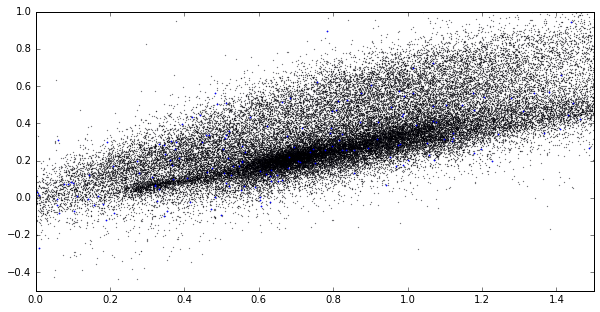

In [22]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(detections['g_mag'] - detections['i_mag'], detections['r_mag'] - detections['i_mag'],s=0.05)
ax.scatter(good_sources['g_mag'] - good_sources['i_mag'], good_sources['r_mag'] - good_sources['i_mag'],\
           color='b',s=0.5)

ax.set_xlim(0.0,1.5)
ax.set_ylim(-0.5,1.0)

### Steps:
1. Use the aperture correction cookbook to calculate aperture corrections for each filter. 
2. Use the zero-point cookbook to calculate zero-points for each filter. (not ready yet)
3. Use the completeness curve cookbook to calculate completeness curves for each filter. 
4. Combine all photometry into a single catalog file using this notebook.
5. Calculate final zero-points by comparing the color-color distributions of sample foreground star populations with those observed in the data. 

### 1. Calculate the aperture corrections for each  filter.
Standard procedure will be to create an individual aperture correction notebook for each filter. Follow the "aperture_correction_cookbook.ipynb" format. Record the aperture corrections both below and on the google spreadsheet, and commit the notebooks to show work.

In [3]:
#aperture corrections:
g_band_apr_cor = 0.3
r_band_aper_cor = 0.3
i_band_aper_cor = 0.3

### 2. Calculate initial zero-points for each filter. 
For galaxies that overlap with SDSS, we will calculate zero-points with overlapping SDSS photometry. Use the sdss_zero_point_cookbook.ipynb to calculate this.

In [2]:
#zero-points
g_band_zpt = 30.
r_band_zpt = 30.
i_band_zpt = 30.

### 3. Calculate the completeness curves for each filter. 
Re-run photometry with new zero-points used, for convenience sake. Then use the fake_star_notebook to perform fake star photometry. Then use the completeness curve notebook to calculate completeness curves and save the completeness object as a pickle.

### 4. Combine the catalogs using the code below.

In [15]:
se = seWrapper.seCatalog()

In [22]:
se_g = seWrapper.seCatalog()
se_g.create_new_catalog_file('ngvs_bg_2_g_final.csv',filter='g')
se_r = seWrapper.seCatalog()
se_r.create_new_catalog_file('ngvs_bg_2_r_final.csv',filter='r')
se_i = seWrapper.seCatalog()
se_i.create_new_catalog_file('ngvs_bg_2_i_final.csv',filter='i')

ValueError: could not convert string to float: 

In [26]:
data = np.loadtxt('ngvs_bg_2_g_final.csv',delimiter=',',dtype='str')

In [31]:
new_catalog = pd.read_csv('ngvs_bg_2_g_final.csv')

In [34]:
bad = new_catalog['mag'] > 90

In [38]:
new_catalog_cut = new_catalog.ix[~bad,:]

In [39]:
new_catalog_cut

,Unnamed: 0,ra,dec,mag,merr,fwhm,ellip,flag
0,0,181.233028,26.832466,26.1346,0.2502,0.0,0.207,4
1,1,181.213433,26.832490,26.3272,0.2863,0.0,0.505,4
3,3,181.176011,26.832615,30.4840,9.6262,0.0,0.346,4
4,4,181.163832,26.832683,27.0291,0.4807,0.0,0.383,6
5,5,181.275251,26.832531,25.6579,0.1831,0.0,0.739,4
6,6,181.140594,26.832592,26.5537,0.3365,0.0,0.240,4
7,7,181.249508,26.832487,25.4978,0.1656,0.0,0.150,4
8,8,181.178630,26.832522,27.2405,0.5672,0.0,0.414,4
9,9,181.254735,26.832664,25.9563,0.2221,0.0,0.691,4
10,10,181.072861,26.832689,26.6038,0.3490,0.0,0.319,4


In [94]:
directory = 'field_1/'
file = directory+'NGVS_BG_1.G.fits'
os.system("sex -c g.sex " + file)

0

In [116]:
np.sum(se_g.mags['g'] < 99)

212763

In [66]:
good = (se.mags['g'] < 90) & (se.mags['g_noback'] < 90)

In [67]:
diffs = se.mags['g'][good] - se.mags['g_noback'][good]

In [50]:
foo = {'foo_1':0.0,'foo_2':1.0,'foo_3':2.0}

(-2, 2)

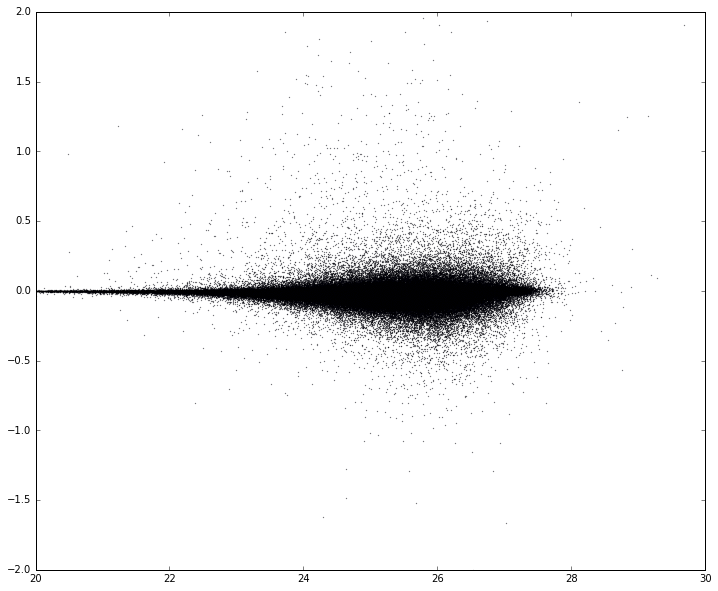

In [72]:
fig,ax = plt.subplots(figsize=(12,10))
ax.scatter(se.mags['g'][good],diffs,s=0.05)
ax.set_xlim(20,30)
ax.set_ylim(-2,2)

In [73]:
foo = dict()

In [78]:
foo['a'] = 0.0
foo['b'] = 1.0
foo['c'] = 2.0

In [88]:
keys = foo.keys()
for i in range(len(list(keys))):
    print(foo[list(keys)[i]])

0.0
1.0
2.0


In [ ]:
for i in range(len(list(keys))):
    truth[:,i] = self.mags[list(keys)[i]] < 99

In [117]:
good_sources = (se_g.mags['g'] < 99) & \
        (se_g.mags['r'] < 99) & \
        (se_g.mags['i'] < 99) & \
        (se_g.flags['g'] < 1) & \
        (se_g.flags['r'] < 1) &\
        (se_g.flags['i'] < 1)

In [119]:
np.sum(good_sources)

80791

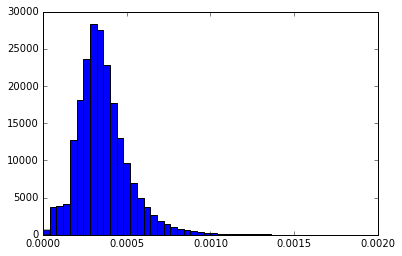

In [134]:
hist = plt.hist(se_g.fwhm['g'],range=(0,0.002),bins=50)